1. Today's computers are highly parallel systems, consisting of multiple CPU cores, multiple processing elements per GPU, and often multiple GPUs per device.
2. Unfortunately **Python (Single-threaded)** is not great way of writing parallel and asynchronous code, atlease not without some extra help.
3. DL frameworks(MXNet, TF) adopt asynchronous programming model to improve performance, while **PyTorch uses python's own scheduler** leading to different perf trade-off.


1. Understanding asynchronous programming works helps us to develop more efficient programs, by proactively reducing computational requirements and mutual dependencies.
2. This allows us to reduce memory overhead and increase processor utilization.

In [1]:
import os 
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# We want to generate a random matrix and multiply it.
# Let's do that both in NumPy and in PyTorch tensor 

device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a,a)

with d2l.Benchmark("numpy"):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)


with d2l.Benchmark("torch"):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device= device)
        b = torch.mm(a, a)


numpy: 0.4791 sec
torch: 0.1761 sec


Huge time difference suggests something else must be going on. <br>
1. By Default, GPU op are async in PyTorch.
2. Forcing PyTorch to finish all computation prior to returning shows what happened previously: *Computation is being executed by the backend(GPU) while the frontend(Python) returns control before the computation is finished, leading to the appearance of significant time gap.*


In [ ]:
with d2l.Benchmark("torch"):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device= device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)


* Pytorch has a frontend for direct interaction with the users, e.g., via Python, as well as backend used by the system to perform the computation.
   1. The frontend and backend work together seamlessly.
   2. When you write PyTorch code (e.g., defining a neural network architecture, specifying loss functions, or training loops), the frontend translates your instructions into 
      computational graphs.
   3. These graphs are then executed by the backend, which performs the actual numerical computations on the available hardware (CPU or GPU).

* Pytorch frontend languages, such as Python and C++.
* Regardless of the frontend programming languages used, the execution of PyTorch programs occurs primarily in the backend of C++ implementation.
* Operations issued from FE passed to BE.
* Backend manages own thread that continously collect and execute queued task.

In [9]:
x = torch.ones((1,2), device=device)
y = torch.ones((1,2), device=device)
z= x*y+2
z

tensor([[3., 3.]])

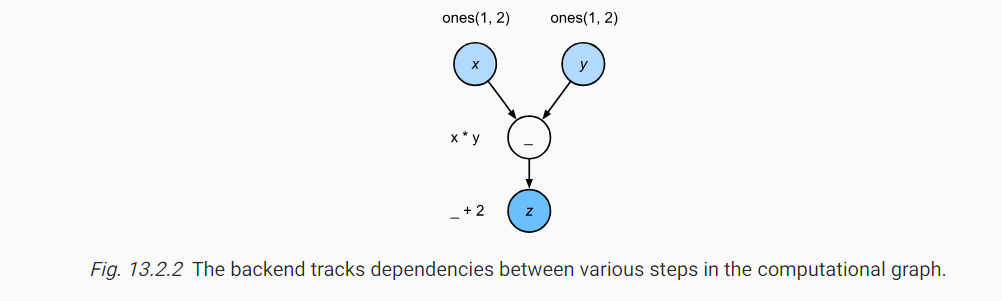

* Whenever the python frontend thread executes one of the first three statements, iit simply returns the task to the backend queue.
* When the last statement's results need to be *printed*, the python frontend thread will wait for C++ backend thread to finish computation the result of the variable z.
* One benefit of this design is that the python frondend thread doesnot need to perform actual computations.
* 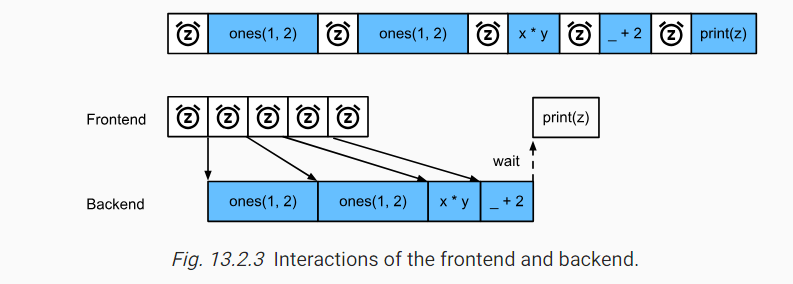